# DATA 612 PROJECT 6
Hands on with AWS

*   Farhod Ibragimov
*   Gillian McGovern

## Introduction

This project looks into how to deploy our existing project 4 to AWS's cloud solution, including how to read from S3, how much computing a free tier AWS EC2 instance can handle, etc. From Amazon's documentation, Amazon Elastic Compute Cloud (Amazon EC2) is a web service that provides secure, resizable compute capacity in the cloud. It is designed to make web-scale cloud computing easier for developers.

## Original Introduction for Project 4

This project delves into evaluating accuracy and other recommender system metrics, specifically diversity, novelty, serendipity. Additionally, we'll see how applying these metric results to our model can improve recommendations. The two models we will be comparing are content-based filtering with BERT, and FunkSVD.

The dataset we will be using is book ratings from Kaggle. This dataset includes data on ratings, users and the books.

Data source: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/data

### Setting Up an EC2 Instance and Connecting

An EC2 instance can be created after creating an AWS account and using the AWS Management Console. The steps can be found here: https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/EC2_GetStarted.html

There are many different AMIs (Amazon Machine Image) to choose from such as Amazon Linux and Ubuntu image. t2.micro instance type will give you 1vCPU and 1 GiB of memory. You can create your own firewall rules or use the default VPC for security. For this project we experimented with allowing SSH traffic from our own IP address.

Connecting to the EC2 is possible through the SSH connection, which gives the ability of remote development through an IDE such as PyCharm. A specific python interpreter can be used for a jupyter notebook running on the EC2 instance.


In [1]:
print("Kernel is alive and well!")



import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import requests, time, pickle
import itertools
import s3fs
import os
from dotenv import load_dotenv
from joblib import Parallel, delayed
#from tqdm.notebook import tqdm
#from google.colab import files
from scipy.sparse import coo_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor, as_completed
#from sentence_transformers import SentenceTransformer
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import root_mean_squared_error
from IPython.display import display, HTML
#from google.colab import drive
#drive.mount('/content/drive')
#uploaded = files.upload()
#!pip install sentence-transformers requests


Kernel is alive and well!


### Load & rename raw data


For this project we wanted to utilize S3, AWS's long term storage. Reading all the files from S3 instead of GitHub took up too much RAM for the free tier EC2 instance causing the script to get stuck. So we decided to run our original project, and upload complete data frames such as our final data frame, `final_slice` (after trimming down the original data) to S3. We then pulled that already complete data frame from S3 to use for our models below.

In order to store a file on S3, you must create an S3 bucket which is a container for files stored on S3. The files stored within a bucket are called objects and can be identified via an object key. For example, `notebook-data/Books.csv` would be an object key.

There are a few Python packages that assist with reading from S3 such as `boto3` and `s3fs`. Here we decided to use `s3fs` which allows pandas to read from s3 directly.

In order for both of us to use the S3 files and collaborate on one file, we could either give permissions to both the IAM user needing access and adding the necessary bucket permissions allowing the IAM user bucket access, or both individually add the files to an S3 bucket, and pull from our own bucket. We decided to do the latter. Since we're running a jupyter notebook on an EC2 instance, we decided to set up an environment variable declaring the S3 bucket to use. We then used `load_dotenv` to configure the run setting in PyCharm to use a `.env` file containing the `S3_BUCKET` variable (note only one of us had to do this).

Additionally, it is easy to gain access to S3 on via the EC2 instance using AWS's cli and using the command `aws configure` to add your AWS access key and secret as environment variables on the box.

In [2]:
# S3 file information

# Loads the .env file (if one is present) for environment variables
load_dotenv('.env')
BUCKET = os.getenv('S3_BUCKET', 'farhodibr')
PREFIX = "notebook-data"
S3_BASE = f"s3://{BUCKET}/{PREFIX}"

# Can read from s3 directly with s3fs
# CSVs took too long to read, so converted the csv files to pickle to decrease the size
# books      = pd.read_csv(f"{S3_BASE}/Books.csv",      storage_options={"anon": False})
# ratings    = pd.read_csv(f"{S3_BASE}/Ratings.csv",    storage_options={"anon": False})
# users      = pd.read_csv(f"{S3_BASE}/Users.csv",      storage_options={"anon": False})
books = pd.read_pickle(f"{S3_BASE}/books.pkl")
ratings = pd.read_pickle(f"{S3_BASE}/ratings.pkl")
users      = pd.read_pickle(f"{S3_BASE}/users.pkl")

isbn_meta  = pd.read_csv(f"{S3_BASE}/isbn_meta.csv",  storage_options={"anon": False})

fs = s3fs.S3FileSystem()
with fs.open(f"{S3_BASE}/embeddings.npy", "rb") as f:
    embeddings = np.load(f)

print("Books:",      books.shape)
print("Ratings:",    ratings.shape)
print("Users:",      users.shape)
print("Embeddings:", embeddings.shape)

Books: (271360, 4)
Ratings: (1149780, 5)
Users: (278858, 3)
Embeddings: (800, 384)


In [4]:
books  = books.rename(columns={
    "ISBN": "isbn",
    "Book-Title": "titles",
    "Book-Author": "authors",
    "Year-Of-Publication": "year_of_publication"
})
books.head()

,isbn,titles,authors,year_of_publication
0,0195153448,Classical Mythology,Mark P. O. Morford,2002
1,0002005018,Clara Callan,Richard Bruce Wright,2001
2,0060973129,Decision in Normandy,Carlo D'Este,1991
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999


In [5]:
# Rename columns
ratings = ratings.rename(columns={
    "User-ID": "user_id",
    "ISBN": "isbn",
    "Book-Rating": "rating"
})
ratings.head()

,user_id,isbn,rating,u_idx,i_idx
0,276725,034545104X,0,0,2966.0
1,276726,0155061224,5,1,225816.0
2,276727,0446520802,0,2,11053.0
3,276729,052165615X,3,3,246838.0
4,276729,0521795028,6,3,246839.0


In [6]:
# Rename columns
users = users.rename(columns={
    "User-ID": "user_id",
    "Location": "location",
    "Age": "age"
})
users.head()

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### Indexing for modeling

We convert `user_id` and `isbn` into zero-based integer indices (`u_idx`, `i_idx`) so we can build sparse matrices and pass arrays into JAX/ALS without string lookups.

In [7]:
user2idx = {u:i for i,u in enumerate(ratings.user_id.unique())}
item2idx = {isbn:i for i,isbn in enumerate(books.isbn.unique())}

ratings['u_idx'] = ratings.user_id.map(user2idx)
ratings['i_idx'] = ratings.isbn  .map(item2idx)

ratings.to_csv('ratings_indexed.csv', index=False)
ratings_df = ratings
ratings_df.head()

,user_id,isbn,rating,u_idx,i_idx
0,276725,034545104X,0,0,2966.0
1,276726,0155061224,5,1,225816.0
2,276727,0446520802,0,2,11053.0
3,276729,052165615X,3,3,246838.0
4,276729,0521795028,6,3,246839.0


### Step 4: Create a Smarter, Smaller Dataset

NOTE: For this project, this code is not executed due to RAM issues. We've already uploaded our final trimmed dataset into S3 and pulled from there.

  The full Book-Crossing dataset is massive and very sparse (most users have only rated a few books). Running models on the whole thing would take forever and might not even give good results.

  So, we do two things here:

  1.  **K-Core Filtering:** We exclude any users who haven't rated at least 15 books and any books that haven't been rated at least 10 times. This gets rid of noise and creates a denser, more reliable core dataset.

  2.  **Head/Tail Sampling:** From that core, we create our final slice. We grab a mix of "head" users (the most active readers) and "long-tail" users (more typical, casual readers). We do the same for books. This ensures our models train on a dataset that reflects a realistic mix of popularity.

In [8]:
def create_k_core_subset(data, min_user_ratings=10, min_item_ratings=5):
    """
    Creates a k-core subset of a ratings dataframe.

    Args:
        data (pd.DataFrame): The ratings dataframe with 'user_id' and 'isbn' columns.
        min_user_ratings (int): The minimum number of ratings a user must have.
        min_item_ratings (int): The minimum number of ratings an item must have.

    Returns:
        pd.DataFrame: A new dataframe representing the k-core.
    """
    print("Starting k-core filtering...")
    k_core_data = data.copy()

    while True:
        original_rows = len(k_core_data)
        print(f"Current dataset size: {original_rows} ratings")

        # Filter by minimum item ratings
        item_counts = k_core_data['isbn'].value_counts()
        items_to_keep = item_counts[item_counts >= min_item_ratings].index
        k_core_data = k_core_data[k_core_data['isbn'].isin(items_to_keep)]

        # Filter by minimum user ratings
        user_counts = k_core_data['user_id'].value_counts()
        users_to_keep = user_counts[user_counts >= min_user_ratings].index
        k_core_data = k_core_data[k_core_data['user_id'].isin(users_to_keep)]

        # Check if we've converged
        if len(k_core_data) == original_rows:
            print(f"\nK-core filtering complete. Final dataset size: {len(k_core_data)} ratings")
            break

    return k_core_data

# Due to RAM issues, must read in final_slice.pkl from S3
PREFIX      = "notebook-data"
FILENAME    = "final_slice.pkl"
REMOTE_PATH = f"s3://{BUCKET}/{PREFIX}/{FILENAME}"
LOCAL_PATH  = Path(FILENAME)

fs = s3fs.S3FileSystem(anon=False)

if fs.exists(REMOTE_PATH):
    print(f"Found {FILENAME} in S3; downloading to local disk...")
    fs.get(REMOTE_PATH, str(LOCAL_PATH))
    ratings_df = pd.read_pickle(LOCAL_PATH)
else:
    print(f"{FILENAME} not found in S3; computing k-core subset now...")
    dense_subset = create_k_core_subset(ratings, min_user_ratings=15, min_item_ratings=10)
    ratings_df = dense_subset
    ratings_df.to_pickle(LOCAL_PATH)
    print(f"Uploading {FILENAME} to S3 for future reuse...")
    fs.put(str(LOCAL_PATH), REMOTE_PATH)

print("Loaded ratings_df with shape:", ratings_df.shape)


Found final_slice.pkl in S3; downloading to local disk...
Loaded ratings_df with shape: (19728, 5)


Final slice shape: (19728, 5)
Distinct users: 707
Distinct books: 800
267/500 books cover 80% → 53.4%


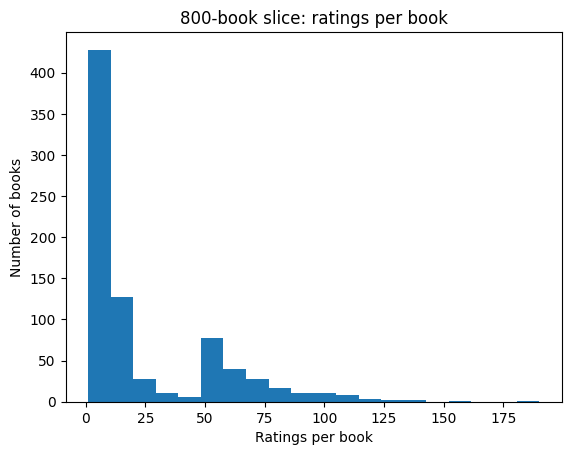

In [9]:
np.random.seed(123)

user_counts = ratings_df.user_id.value_counts()
n_head_users, n_tail_users = 200, 520

head_users = user_counts.nlargest(n_head_users).index

# ensure we don’t over‐sample the tail
tail_candidates = user_counts.index.difference(head_users)
n_tail_users = min(n_tail_users, len(tail_candidates))
tail_users = np.random.choice(tail_candidates, size=n_tail_users, replace=False)

selected_users = pd.Index(np.concatenate([head_users, tail_users]))

# Restrict to those users
user_slice = ratings_df[ratings_df.user_id.isin(selected_users)]

# determine head/tail books in that slice
book_counts_sub = user_slice.isbn.value_counts()
n_head_books, n_tail_books = 200, 600

head_books_sub = book_counts_sub.nlargest(n_head_books).index
tail_candidates_sub = book_counts_sub.index.difference(head_books_sub)
n_tail_books = min(n_tail_books, len(tail_candidates_sub))
tail_books_sub = np.random.choice(tail_candidates_sub, size=n_tail_books, replace=False)

selected_books = pd.Index(np.concatenate([head_books_sub, tail_books_sub]))

# Build final slice
final_slice = user_slice[user_slice.isbn.isin(selected_books)].copy()

# Verify and inspect
print("Final slice shape:", final_slice.shape)
print("Distinct users:", final_slice.user_id.nunique())
print("Distinct books:", final_slice.isbn.nunique())

# Check “long-tail” distribution
bc = final_slice.isbn.value_counts()
cum = (bc.sort_values(ascending=False).cumsum() / bc.sum())
n80 = (cum <= 0.8).sum()
print(f"{n80}/500 books cover 80% → {n80/500:.1%}")

plt.hist(bc.values, bins=20)
plt.title("800-book slice: ratings per book")
plt.xlabel("Ratings per book")
plt.ylabel("Number of books")
plt.show()



We now have a subset of the data to use, but let's confirm the long-tail shape.

### Confirming the long-tail shape

We run a Pareto check and draw both a **survival curve** and a **Zipf (log-log)** plot to prove ~20% of books cover ~80% of ratings.



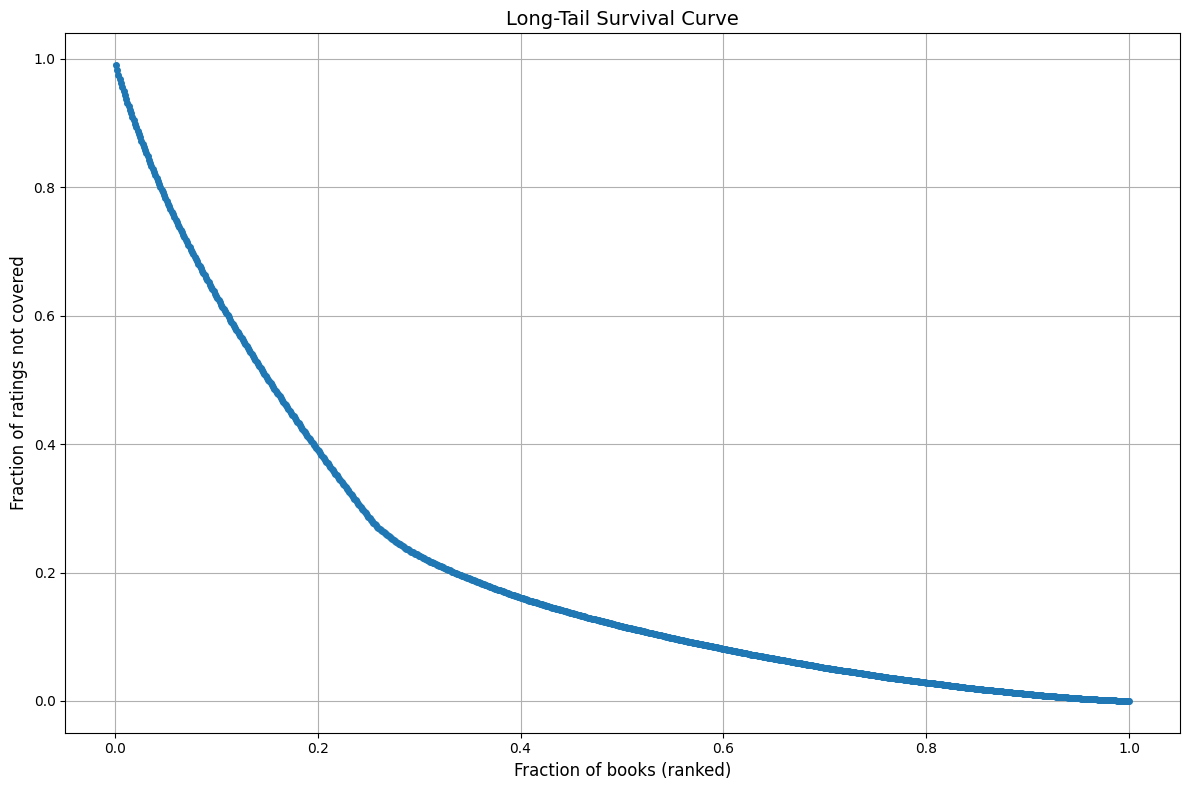

In [10]:
book_counts = final_slice.isbn.value_counts().values
sorted_counts = np.sort(book_counts)[::-1]

cum_share    = np.cumsum(sorted_counts) / sorted_counts.sum()
survival     = 1.0 - cum_share
x_frac       = np.arange(1, len(sorted_counts)+1) / len(sorted_counts)

plt.figure(figsize=(12, 8))
plt.plot(x_frac, survival, lw=3, marker='o', markersize=4)
plt.xlabel("Fraction of books (ranked)", fontsize=12)
plt.ylabel("Fraction of ratings not covered", fontsize=12)
plt.title("Long-Tail Survival Curve", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


The long-tail curve basically shows popularity isn't everything — 20% of books hog 80% of ratings, but the other 80% are full of hidden gems. We want to tap that tail to boost:

**Diversity**: How many different authors/genres end up in the top-n recommendations

**Novelty**: How obscure our recommendations really are (average pop-rank)

**Accuracy Trade-Offs**: What’s our RMSE/Recall hit when we inject more diversity or novelty

By using the tail we keep things fresh, surprise users, and still know when accuracy starts to slip.

### Fetching metadata from OpenLibrary

We hit the Open Library API for each of the 800 `isbn`s, caching in `isbn_meta.pkl` so we don’t hammer them on reruns. We pull title, authors, description, subjects.

In [11]:
isbn_list = final_slice.isbn.unique().tolist()

In [12]:
from concurrent.futures import ThreadPoolExecutor, as_completed

PREFIX       = "notebook-data"
FILENAME     = "isbn_meta.csv"
REMOTE_CSV   = f"s3://{BUCKET}/{PREFIX}/{FILENAME}"
LOCAL_CSV    = Path(FILENAME)

fs = s3fs.S3FileSystem(anon=False)

if fs.exists(REMOTE_CSV):
    print(f"Loading metadata cache from S3: {REMOTE_CSV}")
    df_meta = pd.read_csv(REMOTE_CSV, dtype=str)
    isbn_meta = df_meta.set_index("isbn").to_dict(orient="index")
    print(f"Loaded {len(isbn_meta)} entries from cache")
else:
    print("No metadata cache found in S3; starting fresh")
    isbn_meta = {}

to_fetch = [isbn for isbn in isbn_list if isbn not in isbn_meta]
print(f"Fetching metadata for {len(to_fetch)} new ISBNs…")

def fetch_openlibrary(isbn):
    url    = "https://openlibrary.org/api/books"
    params = {"bibkeys": f"ISBN:{isbn}", "format": "json", "jscmd": "data"}
    resp   = requests.get(url, params=params, timeout=10)
    data   = resp.json()
    key    = f"ISBN:{isbn}"
    if key not in data:
        return isbn, {"title": None, "authors": None, "description": None, "subjects": None}
    info = data[key]
    return isbn, {
        "title":       info.get("title"),
        "authors":     ", ".join(a["name"] for a in info.get("authors", [])),
        "description": (info.get("description") or {}).get("value")
                        if isinstance(info.get("description"), dict)
                        else info.get("description"),
        "subjects":    ", ".join(s["name"] for s in info.get("subjects", []))
    }

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = {executor.submit(fetch_openlibrary, isbn): isbn for isbn in to_fetch}
    for i, future in enumerate(as_completed(futures), start=1):
        isbn_key, data = future.result()
        isbn_meta[isbn_key] = data
        if i % 10 == 0 or i == len(to_fetch):
            print(f"Processed {i}/{len(to_fetch)} ISBNs")

df_meta = (
    pd.DataFrame.from_dict(isbn_meta, orient="index")
      .reset_index()
      .rename(columns={"index":"isbn"})
)

df_meta.to_csv(LOCAL_CSV, index=False)
print(f"Metadata cache written to local CSV: {LOCAL_CSV}")

fs.put(str(LOCAL_CSV), REMOTE_CSV)
print(f"Metadata cache uploaded to S3: {REMOTE_CSV}")

meta_df = df_meta


Loading metadata cache from S3: s3://data612/notebook-data/isbn_meta.csv
Loaded 801 entries from cache
Fetching metadata for 0 new ISBNs…
Metadata cache written to local CSV: isbn_meta.csv
Metadata cache uploaded to S3: s3://data612/notebook-data/isbn_meta.csv


### Build Text Field & Save

We merge the cache into a DataFrame, concatenate title/author/subjects/description into one `text` column, and save `selected_books_with_meta.csv`.

In [13]:
meta_df = pd.DataFrame.from_dict(isbn_meta, orient='index')
meta_df.index.name = 'isbn'

sel_books_df = pd.DataFrame({'isbn': isbn_list}).set_index('isbn').join(meta_df).reset_index()

display(sel_books_df.head())

,isbn,title,authors,description,subjects
0,0061099252,Family pictures,Sue Miller,NaN,"Family relationships, Autistic children, Ficti..."
1,0345334531,The Feast of All Saints,Anne Rice,NaN,"Fiction, Louisiana, fiction, New orleans (la.)..."
2,0345351525,The Queen of the Damned,Anne Rice,NaN,"Fiction, Vampires, Horror tales, horror, rock ..."
3,0345443284,While I Was Gone,Sue Miller,NaN,"Married women, Psychological fiction, Women ve..."
4,0425169863,Point of origin,Patricia Cornwell,NaN,"Women detectives, Medical examiners (Law), Kay..."


In [14]:
sel_books_df['text'] = (
    sel_books_df['title'].fillna('')    + ' ' +
    sel_books_df['authors'].fillna('')  + ' ' +
    sel_books_df['subjects'].fillna('') + ' ' +
    sel_books_df['description'].fillna('')
).str.strip()

DATA_DIR      = Path.home() / "project4" / "data"
LOCAL_CSV     = DATA_DIR / "selected_books_with_meta.csv"
PREFIX        = "notebook-data"
REMOTE_CSV    = f"s3://{BUCKET}/{PREFIX}/selected_books_with_meta.csv"

DATA_DIR.mkdir(parents=True, exist_ok=True)

sel_books_df.to_csv(LOCAL_CSV, index=False)
print(f"Saved local CSV: {LOCAL_CSV}")

fs = s3fs.S3FileSystem(anon=False)
fs.put(str(LOCAL_CSV), REMOTE_CSV)
print(f"Uploaded to S3: {REMOTE_CSV}")


Saved local CSV: /home/ubuntu/project4/data/selected_books_with_meta.csv
Uploaded to S3: s3://data612/notebook-data/selected_books_with_meta.csv


In [15]:
#from google.colab import files
#files.download('selected_books_with_meta.csv')

### TF-IDF Content-based recommender model

We load the enriched books, vectorize the `text` with TF-IDF, compute cosine similarities, and write a `content_based_recommend()` function.

In [16]:
ratings_subset = final_slice
books_subset_metadata = sel_books_df

In [17]:
tfidf = TfidfVectorizer(stop_words='english', max_features=6000)
X= tfidf.fit_transform(books_subset_metadata.text)

cos_sim= cosine_similarity(X, X)

isbn_to_index = {
    isbn: idx
    for idx, isbn in enumerate(books_subset_metadata.isbn)
}
index_to_isbn = {
    idx: isbn
    for isbn, idx in isbn_to_index.items()
}

def content_based_recommend(isbn, top_n = 10):
  i = isbn_to_index[isbn]
  sims = cos_sim[i].copy()
  sims[i] = -1
  best = np.argpartition(-sims, top_n)[:top_n]
  recs = sorted(((idx, sims[idx]) for idx in best), key=lambda x: -x[1])
  return[(index_to_isbn[idx], float(score)) for idx,score in recs]

test_isbn = books_subset_metadata.loc[0, 'isbn']
print("Seed ISBN:", test_isbn)
print("Recommendations:", content_based_recommend(test_isbn, 5))

Seed ISBN: 0061099252
Recommendations: [('0553268880', 0.2893896478006904), ('0671028014', 0.28238741352214686), ('0440202043', 0.24568448586612263), ('0140070206', 0.23770233256629283), ('0440486599', 0.22875510672631255)]


For ISBN 0061099252, the content-based recommendations are 0553268880, 0671028014, 0440202043, 0140070206 and 0440486599. This is great, but we can improve these recommendations by using the info for each book.

Now let's look at the book metadata:

In [18]:
meta_lookup = books_subset_metadata.set_index('isbn')[['title', 'authors', 'subjects']]

def get_book_info(isbn):
    """
    Returns metadata for a single ISBN.
    """
    info = meta_lookup.loc[isbn]
    return {
        'isbn':     isbn,
        'title':    info['title'],
        'author':   info['authors'],
        'subjects': info['subjects']
    }

def content_based_recommend_with_info(isbn, top_n=10):
    """
    Returns a DataFrame of top_n recommendations for the seed ISBN,
    including title, author, subjects, and similarity score.
    """
    recs = content_based_recommend(isbn, top_n)
    rows = []
    for rec_isbn, score in recs:
        info = get_book_info(rec_isbn)
        rows.append({
            'isbn':     rec_isbn,
            'title':    info['title'],
            'author':   info['author'],
            'subjects': info['subjects'],
            'cos_sim score':    score
        })
    return pd.DataFrame(rows)

seed_isbn = books_subset_metadata.loc[0, 'isbn']
seed_info = get_book_info(seed_isbn)

print("Seed book:")
print(f"  ISBN:     {seed_info['isbn']}")
print(f"  Title:    {seed_info['title']}")
print(f"  Author:   {seed_info['author']}")
print(f"  Subjects: {seed_info['subjects']}\n")

print("Top recommendations:")
recommendations_df = content_based_recommend_with_info(seed_isbn, top_n=5)
recommendations_df


Seed book:
  ISBN:     0061099252
  Title:    Family pictures
  Author:   Sue Miller
  Subjects: Family relationships, Autistic children, Fiction, Care, Fiction, family life, general

Top recommendations:


,isbn,title,author,subjects,cos_sim score
0,0553268880,The Prince of Tides,Pat Conroy,"Fiction, Brothers and sisters, Social life and...",0.289390
1,0671028014,Star,V. C. Andrews,"Fiction, Girls, Families, Family, Family life,...",0.282387
2,0440202043,The shell seekers.,Rosamunde Pilcher,"Conflict of generations, England, Family relat...",0.245684
3,0140070206,Ironweed,"Kennedy, William","Fiction, Family in fiction, Family, Families, ...",0.237702
4,0440486599,"Then again, maybe I won't",Judy Blume,"Emotional problems, Emotional problems of chil...",0.228755


We now have title, author, subjects, and similarity score. We can see that the recommendations are fiction and involve families.

###   BERT Content-based model

This is our second, more sophisticated content model. Instead of just looking at keywords like TF-IDF, **BERT** is a powerful language model that understands the *meaning and context* of the words in our `text` field.

We use a pre-trained BERT model (`all-MiniLM-L6-v2`) to convert each book's text into a high-quality numerical vector called an \"embedding.\" These embeddings are much richer than TF-IDF vectors.

 We then use the same cosine similarity trick to find books with the most similar embeddings. The expectation is that BERT will give us more nuanced and conceptually relevant recommendations.


In [19]:
PREFIX       = "notebook-data"
FNAME        = "embeddings.npy"
LOCAL_PATH   = FNAME
REMOTE_PATH  = f"s3://{BUCKET}/{PREFIX}/{FNAME}"

fs = s3fs.S3FileSystem(anon=False)

if os.path.exists(LOCAL_PATH):
    embeddings = np.load(LOCAL_PATH)
    print(f"Loaded embeddings from local file: {LOCAL_PATH}")
elif fs.exists(REMOTE_PATH):
    print(f"Downloading embeddings from S3: {REMOTE_PATH}")
    with fs.open(REMOTE_PATH, "rb") as f:
        embeddings = np.load(f)
    np.save(LOCAL_PATH, embeddings)
    print(f"Saved embeddings to local file: {LOCAL_PATH}")
else:
    raise FileNotFoundError(f"Embeddings file not found locally or in S3 at {REMOTE_PATH}")

cos_sim_bert = cosine_similarity(embeddings, embeddings)

isbn_to_idx_bert = {isbn: idx for idx, isbn in enumerate(sel_books_df['isbn'])}
idx_to_isbn_bert = {idx: isbn for isbn, idx in isbn_to_idx_bert.items()}

def bert_recommend(isbn, top_n=10):
    if isbn not in isbn_to_idx_bert:
        raise ValueError(f"ISBN {isbn} not found in dataset")
    i    = isbn_to_idx_bert[isbn]
    sims = cos_sim_bert[i].copy()
    sims[i] = -1  # exclude the seed itself
    best_idxs = np.argpartition(-sims, top_n)[:top_n]
    recs = sorted(((idx, sims[idx]) for idx in best_idxs), key=lambda x: -x[1])
    return [(idx_to_isbn_bert[idx], float(score)) for idx, score in recs]

seed = sel_books_df.loc[0, 'isbn']
print("Seed ISBN:", seed)
print("Top 5 BERT recs:", bert_recommend(seed, 5))



Saved embeddings to local file: embeddings.npy
Seed ISBN: 0061099252
Top 5 BERT recs: [('0671028014', 0.7182744741439819), ('0440226104', 0.6873708963394165), ('0373711328', 0.6859381198883057), ('1551665557', 0.676663339138031), ('0140070206', 0.6735764741897583)]


In [20]:
PREFIX      = "notebook-data"
FILENAME    = "selected_books_with_meta.csv"
REMOTE_CSV  = f"s3://{BUCKET}/{PREFIX}/{FILENAME}"
LOCAL_CSV   = "selected_books_with_meta.csv"

fs = s3fs.S3FileSystem(anon=False)

if fs.exists(REMOTE_CSV):
    print(f"Loading metadata CSV from S3: {REMOTE_CSV}")
    sel_books_df = pd.read_csv(REMOTE_CSV, storage_options={"anon": False}, encoding='latin1')
else:
    print(f"No remote CSV found; loading local file and uploading to S3")
    sel_books_df = pd.read_csv(LOCAL_CSV, encoding='latin1')
    fs.put(LOCAL_CSV, REMOTE_CSV)
    print(f"Uploaded local CSV to S3: {REMOTE_CSV}")

meta = sel_books_df.set_index('isbn')[['title','authors','subjects']]

def recs_with_meta(recs, model_name):
    rows = []
    for isbn, score in recs:
        if isbn in meta.index:
            info = meta.loc[isbn]
            rows.append({
                'model':    model_name,
                'isbn':     isbn,
                'title':    info['title'],
                'author':   info['authors'],
                'subjects': info['subjects'],
                'score':    score
            })
    return pd.DataFrame(rows)

seed      = sel_books_df.loc[0, 'isbn']
tfidf_recs = content_based_recommend(seed, 5)
bert_recs  = bert_recommend(seed, 5)

df_tfidf = recs_with_meta(tfidf_recs, 'TF-IDF')
df_bert  = recs_with_meta(bert_recs,  'BERT')
pd.concat([df_tfidf, df_bert], ignore_index=True)


Loading metadata CSV from S3: s3://data612/notebook-data/selected_books_with_meta.csv


,model,isbn,title,author,subjects,score
0,TF-IDF,0553268880,The Prince of Tides,Pat Conroy,"Fiction, Brothers and sisters, Social life and...",0.289390
1,TF-IDF,0671028014,Star,V. C. Andrews,"Fiction, Girls, Families, Family, Family life,...",0.282387
2,TF-IDF,0440202043,The shell seekers.,Rosamunde Pilcher,"Conflict of generations, England, Family relat...",0.245684
3,TF-IDF,0140070206,Ironweed,"Kennedy, William","Fiction, Family in fiction, Family, Families, ...",0.237702
4,TF-IDF,0440486599,"Then again, maybe I won't",Judy Blume,"Emotional problems, Emotional problems of chil...",0.228755
5,BERT,0671028014,Star,V. C. Andrews,"Fiction, Girls, Families, Family, Family life,...",0.718274
6,BERT,0440226104,Black and blue,Anna Quindlen,"Mothers and sons, fiction, Florida, fiction, M...",0.687371
7,BERT,0373711328,Keeping Faith,Janice Macdonald,"Fiction, Grandparent and child, Mothers and da...",0.685938
8,BERT,1551665557,The Family Way,Jayne Ann Krentz,"Fiction, Romance, Contemporary, Pregnancy, fic...",0.676663
9,BERT,0140070206,Ironweed,"Kennedy, William","Fiction, Family in fiction, Family, Families, ...",0.673576


We can see here that using BERT gives us a much higher cosine similarity. For BERT, Star by V. C. Andrews is actually the top recommendation with a similarity score of 0.718274. Additionally, BERT's recommendations only share two titles with TF-IDF, with the rest being different. Being able to use the context of a sentence via BERT embeddings is more useful than finding the significance of words via TF-IDF.

In [21]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_diversity(recs_by_user, isbn_to_idx, item_embeddings):
    """
    Compute mean pairwise diversity (1 – cosine_similarity) of top-N lists.

    Params:
    - recs_by_user: dict[user_id] → list of ISBNs in that user’s top-N recs
    - isbn_to_idx:  dict mapping ISBN → row index in item_embeddings
    - item_embeddings: np.ndarray, shape (n_items, dim)

    Returns:
    - avg_diversity: float
    """
    diversities = []
    for user, rec_isbns in recs_by_user.items():
        # translate ISBN → embedding rows, skip missing
        idxs = [isbn_to_idx[isbn] for isbn in rec_isbns if isbn in isbn_to_idx]
        if len(idxs) < 2:
            continue
        vecs = item_embeddings[idxs]
        sims = cosine_similarity(vecs, vecs)
        # take upper-triangle off-diagonal
        i_u, j_u = np.triu_indices_from(sims, k=1)
        pair_sims = sims[i_u, j_u]
        diversities.append((1 - pair_sims).mean())

    return float(np.mean(diversities)) if diversities else 0.0


In [22]:
#embeddings = model.encode(
#    sel_books_df['text'].tolist(),
#    show_progress_bar=True,
#    convert_to_numpy=True
#)

In [23]:
def build_recs_by_user(final_slice, recommend_fn, top_n=10, seed_fn=None):
    """
    Build a dict of user_id → list of recommended ISBNs for any model.

    Params:
    - final_slice: DataFrame with columns ['user_id', 'isbn', 'rating', ...]
    - recommend_fn: function(seed_isbn, top_n) → list of (isbn, score)
    - top_n: how many recs per user
    - seed_fn: optional function(user_id) → seed_isbn. Defaults to highest-rated ISBN in final_slice.

    Returns:
    - recs_by_user: dict mapping user_id → list of ISBN strings
    """
    if seed_fn is None:
        # default: pick highest-rated ISBN that the user has in final_slice
        def seed_fn(u):
            sub = final_slice[final_slice['user_id'] == u]
            if sub.empty:
                return None
            return sub.sort_values('rating', ascending=False)['isbn'].iat[0]

    recs_by_user = {}
    for u in final_slice['user_id'].unique():
        seed = seed_fn(u)
        if not seed:
            continue
        recs = recommend_fn(seed, top_n)
        recs_by_user[u] = [isbn for isbn, _ in recs]
    return recs_by_user

In [24]:
recs_bert = build_recs_by_user(final_slice, bert_recommend, top_n=10)
div = compute_diversity(recs_bert, isbn_to_idx_bert, embeddings)
print("Model diversity:", div)

Model diversity: 0.3743830919265747


### SVD Model

This model, **FunkSVD**, is a collaborative filtering model. It knows *nothing* about the books' content (no titles, no descriptions). Its only source of information is the user-item ratings matrix: who rated what, and what score they gave.

The core idea is to find hidden patterns in user ratings. It breaks down the ratings matrix into two smaller matrices: one representing user "tastes" and another representing item "attributes." To make a prediction, it just multiplies them back together. The way it works is that it learns these tastes and attributes automatically from the data.


In [25]:
from scipy.sparse.linalg import svds
from sklearn.metrics import root_mean_squared_error

In [26]:
# Merge data frames so we have the title as part of the ratings
ratings_subset_v2 = pd.merge(final_slice, sel_books_df, on="isbn")

# Create the user-item utility matrix
ratings_matrix = ratings_subset_v2.pivot_table(
    index="user_id",
    columns="title",
    values="rating"
)
# Get the raw ratings matrix as a NumPy array
original_ratings = ratings_matrix.values
# Create a mask to only calculate error on original, non-empty ratings
mask = ~np.isnan(original_ratings)


In [27]:
R = ratings_matrix.values.copy()

#Mask zeros as NaN so 0’s aren’t treated as real ratings
R[R == 0] = np.nan

#  Build train/test splits on non-NaN entries
all_coords = np.argwhere(~np.isnan(R))
np.random.seed(42)
np.random.shuffle(all_coords)

test_size  = int(0.2 * len(all_coords))
test_idx   = all_coords[:test_size]
train_idx  = all_coords[test_size:]

train_coords = [(i, j, R[i, j]) for i, j in train_idx]
test_coords  = [(i, j, R[i, j]) for i, j in test_idx]

R_train = np.full_like(R, np.nan)
for i, j, val in train_coords:
    R_train[i, j] = val

n_users, n_items = R.shape

In [28]:
#Compute user means on the train data, keep as (n_users, 1)
user_means_arr = np.nanmean(R_train, axis=1)
global_mean    = np.nanmean(user_means_arr)
user_means_arr = np.where(np.isnan(user_means_arr), global_mean, user_means_arr)
user_means     = user_means_arr.reshape(-1, 1)
#Center the train matrix, then build a sparse version for svds
R_centered = R_train - user_means
R_sparse   = csr_matrix(np.nan_to_num(R_centered))



/tmp/ipykernel_2076/158033337.py:2: RuntimeWarning: Mean of empty slice
  user_means_arr = np.nanmean(R_train, axis=1)



Sample predictions at k=10:
  pred=8.457, actual=8.0
  pred=8.596, actual=9.0
  pred=6.967, actual=5.0
  pred=8.818, actual=10.0
  pred=7.615, actual=3.0

Sample predictions at k=100:
  pred=8.041, actual=8.0
  pred=8.472, actual=9.0
  pred=7.147, actual=5.0
  pred=8.629, actual=10.0
  pred=7.529, actual=3.0
Best train k=100 with Train RMSE=0.4120
Best test  k=10 with Test RMSE =1.6913
 Plotting results...


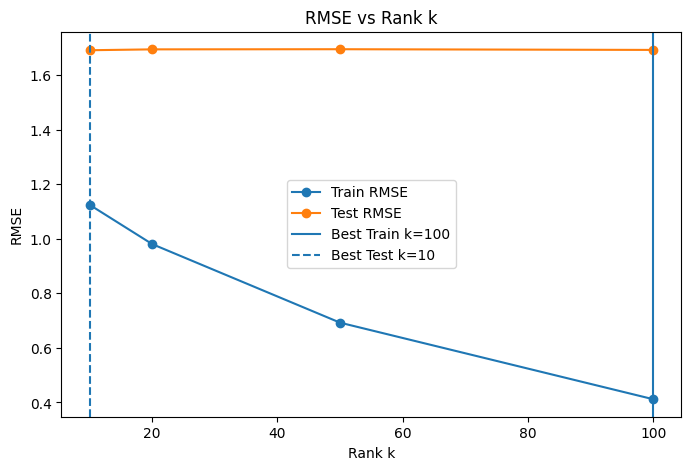


Optimal k = 10 with a Test RMSE of 1.6913


In [29]:
#  Prepare index and truth lists for RMSE
train_rows  = [i for i, j, _ in train_coords]
train_cols  = [j for i, j, _ in train_coords]
train_truth = [v for i, j, v in train_coords]

test_rows   = [i for i, j, _ in test_coords]
test_cols   = [j for i, j, _ in test_coords]
test_truth  = [v for i, j, v in test_coords]

#  Loop over k: truncated SVD -> reconstruct -> RMSE
train_rmse_values = []
test_rmse_values  = []

k_values = [10, 20, 50, 100]  # adjust or extend this list as needed
for k in k_values:
    ncv_val = min(2 * k + 1, n_users - 1, n_items - 1)
    U, sigma, Vt = svds(R_sparse, k=k, ncv=ncv_val)

    # Reconstruct inside the loop
    R_hat_centered = U @ np.diag(sigma) @ Vt
    R_hat = R_hat_centered + user_means

    # For sample debugging, print in k=10 and k=100
    if k in (10, 100):
        print(f"\nSample predictions at k={k}:")
        for idx in range(5):
            r, c, actual = test_rows[idx], test_cols[idx], test_truth[idx]
            print(f"  pred={R_hat[r, c]:.3f}, actual={actual}")

    # Compute RMSE on train and test sets
    train_rmse = root_mean_squared_error(train_truth, R_hat[train_rows, train_cols])
    test_rmse  = root_mean_squared_error(test_truth,  R_hat[test_rows,  test_cols])

    train_rmse_values.append(train_rmse)
    test_rmse_values.append(test_rmse)
    best_train_idx  = np.argmin(train_rmse_values)
    best_train_k    = k_values[best_train_idx]
    best_train_rmse = train_rmse_values[best_train_idx]

    best_test_idx   = np.argmin(test_rmse_values)
    best_test_k     = k_values[best_test_idx]
    best_test_rmse  = test_rmse_values[best_test_idx]
# After loop: plot or pick best k
best_idx = np.argmin(test_rmse_values)
best_k   = k_values[best_idx]
best_rmse= test_rmse_values[best_idx]
print(f"Best train k={best_train_k} with Train RMSE={best_train_rmse:.4f}")
print(f"Best test  k={best_test_k} with Test RMSE ={best_test_rmse:.4f}")
#  Plot and Find the True Optimal k
print(" Plotting results...")
plt.figure(figsize=(8,5))
plt.plot(k_values, train_rmse_values, marker='o', label='Train RMSE')
plt.plot(k_values, test_rmse_values, marker='o', label='Test RMSE')
plt.axvline(best_train_k, linestyle='-', label=f'Best Train k={best_train_k}')
plt.axvline(best_test_k,  linestyle='--', label=f'Best Test k={best_test_k}')
plt.xlabel('Rank k')
plt.ylabel('RMSE')
plt.title('RMSE vs Rank k')
plt.legend()
plt.show()

if not np.all(np.isnan(test_rmse_values)):
    min_test_rmse = np.nanmin(test_rmse_values)
    best_k = k_values[np.nanargmin(test_rmse_values)]
    print(f"\nOptimal k = {best_k} with a Test RMSE of {min_test_rmse:.4f}")
else:
    print("\nCould not find a stable k. All values failed.")

After training the data, the optimal k value (number of latent features) for the test set is 10 with an RMSE value of 1.7.

In [30]:
# 1) What do your "true" ratings actually look like?
print("Sample train_truth:", np.array(train_truth[:10],dtype=float))
print("Sample test_truth: ",  np.array(test_truth[:10],dtype=float))

# 2) What’s the overall scale?
import numpy as np
print("Rating matrix min/max:",
      np.nanmin(ratings_matrix), "→", np.nanmax(ratings_matrix))

# 3) Check the global mean you’re using
global_mean = np.mean(train_truth)
print("Computed global_mean:", global_mean)

# 4) Verify your baseline calculation
mse = np.mean([(r - global_mean)**2 for r in test_truth])
print(f"Baseline MSE: {mse:.4f}  →  RMSE: {np.sqrt(mse):.4f}")

Sample train_truth: [ 7.  7. 10.  8.  9.  7.  7. 10.  8.  7.]
Sample test_truth:  [ 8.  9.  5. 10.  3.  9.  6.  7.  9.  7.]
Rating matrix min/max: 0.0 → 10.0
Computed global_mean: 7.931830099632931
Baseline MSE: 3.0856  →  RMSE: 1.7566


In [31]:
def train_funk_svd_with_early_stopping(
    train_coords,
    val_coords,
    n_users,
    n_items,
    n_factors,
    n_epochs,
    learning_rate,
    reg,
    patience=5,
    return_history=False
):
    # Initialize user/item factors
    P = np.random.normal(scale=1.0/n_factors, size=(n_users, n_factors))
    Q = np.random.normal(scale=1.0/n_factors, size=(n_items, n_factors))
    # Histories
    train_rmse_hist = []
    val_rmse_hist   = []
    best_val = np.inf
    wait = 0
    # Training loop with tqdm progress bar
    for epoch in range(1, n_epochs+1):
        # SGD updates over train_coords
        for u, i, r in train_coords:
            pred = P[u, :].dot(Q[i, :])
            err  = r - pred
            # gradient updates
            P[u, :] += learning_rate * (err * Q[i, :] - reg * P[u, :])
            Q[i, :] += learning_rate * (err * P[u, :] - reg * Q[i, :])
        # compute RMSEs
        train_preds = [P[u, :].dot(Q[i, :]) for u, i, _ in train_coords]
        train_truth = [r for _, _, r in train_coords]
        curr_train_rmse = root_mean_squared_error(train_truth, train_preds)
        val_preds   = [P[u, :].dot(Q[i, :]) for u, i, _ in val_coords]
        val_truth   = [r for _, _, r in val_coords]
        curr_val_rmse = root_mean_squared_error(val_truth, val_preds)
        train_rmse_hist.append(curr_train_rmse)
        val_rmse_hist.append(curr_val_rmse)
        # early stopping check
        if curr_val_rmse < best_val:
            best_val = curr_val_rmse
            best_P, best_Q = P.copy(), Q.copy()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                # restore best factors
                P, Q = best_P, best_Q
                break
    # Return with or without history
    if return_history:
        return P, Q, { 'train_rmse': train_rmse_hist,
                         'val_rmse':   val_rmse_hist }
    return P, Q

Here we run a grid search to find the best settings (hyperparameters) for the model to get the lowest possible prediction error (RMSE).

In [32]:
import itertools
import numpy as np
from sklearn.metrics import mean_squared_error

# ─── Helper: RMSE ─────────────────────────────────────────────────────────────
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ─── Evaluate a single hyperparameter setting ────────────────────────────────
def evaluate_model(params, train_coords, test_coords, n_users, n_items):
    k, lr, reg_param, epochs = params
    # Train with early stopping (using test_coords as the validation set)
    P, Q = train_funk_svd_with_early_stopping(
        train_coords=train_coords,
        val_coords=test_coords,
        n_users=n_users,
        n_items=n_items,
        n_factors=k,
        n_epochs=epochs,
        learning_rate=lr,
        reg=reg_param,
        patience=5
    )
    # Evaluate on the same test set
    R_hat = P @ Q.T
    rows  = [u for u, i, _ in test_coords]
    cols  = [i for u, i, _ in test_coords]
    truth = [r for u, i, r in test_coords]
    preds = R_hat[rows, cols]
    rmse  = root_mean_squared_error(truth, preds)
    return {'k': k, 'lr': lr, 'reg': reg_param, 'epochs': epochs, 'rmse': rmse}

# ─── Your hyperparameter grid ────────────────────────────────────────────────
param_grid = {
    'n_factors':    [20, 30, 40, 50, 70, 90],
    'learning_rate':[0.005, 0.01],
    'reg':          [0.02, 0.1],
    'n_epochs':     [20, 40, 50, 60]
}
param_combinations = list(itertools.product(
    param_grid['n_factors'],
    param_grid['learning_rate'],
    param_grid['reg'],
    param_grid['n_epochs']
))

# ─── Run the grid search ─────────────────────────────────────────────────────
total = len(param_combinations)
print(f"Running FunkSVD Grid Search: {total} combinations")

results = []
for idx, params in enumerate(param_combinations, start=1):
    res = evaluate_model(params,
                         train_coords,
                         test_coords,
                         n_users,
                         n_items)
    results.append(res)
    if idx % 10 == 0 or idx == total:
        print(f"  → {idx}/{total} done (rmse={res['rmse']:.4f})")

# ─── Report the best setting ─────────────────────────────────────────────────
best = min(results, key=lambda x: x['rmse'])
print("\n--- Best FunkSVD Model ---")
print(f"Test RMSE:       {best['rmse']:.4f}")
print(f"n_factors (k):   {best['k']}")
print(f"learning_rate:   {best['lr']}")
print(f"reg_param:       {best['reg']}")
print(f"n_epochs:        {best['epochs']}")


Running FunkSVD Grid Search: 96 combinations
  → 10/96 done (rmse=3.0193)
  → 20/96 done (rmse=2.9956)
  → 30/96 done (rmse=2.8861)
  → 40/96 done (rmse=2.8823)
  → 50/96 done (rmse=3.0158)
  → 60/96 done (rmse=2.8810)
  → 70/96 done (rmse=2.9590)
  → 80/96 done (rmse=2.8299)
  → 90/96 done (rmse=2.8531)
  → 96/96 done (rmse=2.8239)

--- Best FunkSVD Model ---
Test RMSE:       2.8229
n_factors (k):   90
learning_rate:   0.01
reg_param:       0.1
n_epochs:        50


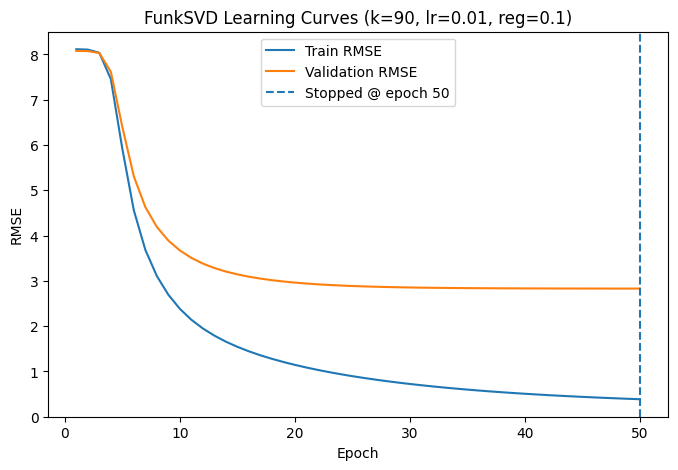

In [33]:
best_k      = best['k']
best_lr     = best['lr']
best_reg    = best['reg']
best_epochs = best['epochs']

# Re-train with history
P_funk, Q_funk, history = train_funk_svd_with_early_stopping(
    train_coords=train_coords,
    val_coords=test_coords,
    n_users=n_users,
    n_items=n_items,
    n_factors=best_k,
    n_epochs=best_epochs,
    learning_rate=best_lr,
    reg=best_reg,
    patience=5,
    return_history=True
    )

# Plot learning curves
epochs = np.arange(1, len(history['train_rmse'])+1)
plt.figure(figsize=(8,5))
plt.plot(epochs, history['train_rmse'], label='Train RMSE')
plt.plot(epochs, history['val_rmse'],   label='Validation RMSE')
plt.axvline(len(history['val_rmse']), linestyle='--', label=f"Stopped @ epoch {len(history['val_rmse'])}")
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title(f'FunkSVD Learning Curves (k={best_k}, lr={best_lr}, reg={best_reg})')
plt.legend()
plt.show()

### Metrics Calculation

We know that from a business perspective, it is not enough to look at the accuracy of a model when choosing the best recommender. To create useful recommendations that will increase customer satisfaction, we must include additional performance metrics. Now we will calculate Diversity, Novelty, and Serendipity for the BERT and FunkSVD models.

In [34]:
def build_recs_by_user(final_slice, recommend_fn, top_n=10, seed_fn=None):
    """
    Build a dict of user_id → list of recommended ISBNs for any model.
    """
    if seed_fn is None:
        def seed_fn(u):
            sub = final_slice[final_slice['user_id'] == u]
            if sub.empty: return None
            return sub.sort_values('rating', ascending=False)['isbn'].iat[0]

    recs_by_user = {}
    for u in final_slice['user_id'].unique():
        seed = seed_fn(u)
        if not seed or seed not in isbn_to_idx_bert:
            continue
        recs = recommend_fn(seed, top_n)
        recs_by_user[u] = [isbn for isbn, _ in recs]
    return recs_by_user


In [35]:
def compute_diversity(recs_by_user, item_embeddings, isbn_to_idx):
    """
    Computes the average intra-list diversity of recommendations.
    """
    user_diversities = []
    for user_id, rec_isbns in recs_by_user.items():
        rec_indices = [isbn_to_idx[isbn] for isbn in rec_isbns if isbn in isbn_to_idx]
        if len(rec_indices) < 2: continue

        rec_vectors = item_embeddings[rec_indices]
        similarity_matrix = cosine_similarity(rec_vectors)

        upper_triangle_indices = np.triu_indices_from(similarity_matrix, k=1)
        if upper_triangle_indices[0].size > 0:
            avg_similarity = np.mean(similarity_matrix[upper_triangle_indices])
            user_diversities.append(1 - avg_similarity)

    return np.mean(user_diversities) if user_diversities else 0

In [36]:
def compute_novelty(recs_by_user, popularity_ranks):
    """
    Computes the average novelty of recommendations.
    """
    user_novelties = []
    for user_id, rec_isbns in recs_by_user.items():
        novelties = [
            -np.log2(popularity_ranks.get(isbn, len(popularity_ranks)) / len(popularity_ranks))
            for isbn in rec_isbns
        ]
        if novelties: user_novelties.append(np.mean(novelties))
    return np.mean(user_novelties) if user_novelties else 0



In [37]:
def compute_novelty(recs_by_user, popularity_ranks):
    """
    Computes the average novelty of recommendations.
    """
    user_novelties = []
    for user_id, rec_isbns in recs_by_user.items():
        novelties = [
            -np.log2(popularity_ranks.get(isbn, len(popularity_ranks)) / len(popularity_ranks))
            for isbn in rec_isbns
        ]
        if novelties: user_novelties.append(np.mean(novelties))
    return np.mean(user_novelties) if user_novelties else 0

In [38]:
def compute_serendipity(recs_by_user, user_history, item_embeddings, isbn_to_idx):
    """
    Computes serendipity of recommendations.
    """
    user_serendipities = []
    for user_id, rec_isbns in recs_by_user.items():
        history_isbns = user_history.get(user_id, [])
        history_indices = [isbn_to_idx[isbn] for isbn in history_isbns if isbn in isbn_to_idx]

        if not history_indices: continue

        history_vectors = item_embeddings[history_indices]
        serendipities = []
        for rec_isbn in rec_isbns:
            if rec_isbn in history_isbns or rec_isbn not in isbn_to_idx: continue

            rec_idx = isbn_to_idx[rec_isbn]
            rec_vector = item_embeddings[rec_idx].reshape(1, -1)

            max_sim_to_history = cosine_similarity(rec_vector, history_vectors).max()
            unexpectedness = 1 - max_sim_to_history
            relevance = 1.0

            serendipities.append(unexpectedness * relevance)

        if serendipities: user_serendipities.append(np.mean(serendipities))

    return np.mean(user_serendipities) if user_serendipities else 0

In [39]:
popularity = final_slice['isbn'].value_counts()
popularity_ranks = popularity.rank(method='first', ascending=False)
user_history = final_slice.groupby('user_id')['isbn'].apply(list).to_dict()

In [40]:
print("\nCalculating metrics for BERT model...")
recs_bert = build_recs_by_user(final_slice, bert_recommend, top_n=10)

diversity_bert = compute_diversity(recs_bert, embeddings, isbn_to_idx_bert)
novelty_bert = compute_novelty(recs_bert, popularity_ranks)
serendipity_bert = compute_serendipity(recs_bert, user_history, embeddings, isbn_to_idx_bert)

print(f"BERT Diversity: {diversity_bert:.4f}")
print(f"BERT Novelty: {novelty_bert:.4f}")
print(f"BERT Serendipity: {serendipity_bert:.4f}")


Calculating metrics for BERT model...
BERT Diversity: 0.3744
BERT Novelty: 2.0300
BERT Serendipity: 0.3159


In [41]:
svd_user_map = {u: i for i, u in enumerate(ratings_matrix.index)}
svd_item_map_to_idx = {title: i for i, title in enumerate(ratings_matrix.columns)}
svd_idx_to_title = {i: title for title, i in svd_item_map_to_idx.items()}
title_to_isbn = sel_books_df.set_index('title')['isbn'].to_dict()
R_hat_funk = P_funk @ Q_funk.T

In [42]:
def funksvd_recommend(user_id, top_n=10):
    user_idx = svd_user_map.get(user_id)
    if user_idx is None: return []

    scores = R_hat_funk[user_idx, :]
    seen_titles = [sel_books_df[sel_books_df['isbn'] == isbn]['title'].values[0] for isbn in user_history.get(user_id, []) if sel_books_df[sel_books_df['isbn'] == isbn]['title'].values.size > 0]
    seen_indices = [svd_item_map_to_idx[title] for title in seen_titles if title in svd_item_map_to_idx]
    scores[seen_indices] = -np.inf # Mask seen items

    top_indices = np.argsort(scores)[::-1][:top_n]
    recs = []
    for item_idx in top_indices:
        title = svd_idx_to_title.get(item_idx)
        if title:
            isbn = title_to_isbn.get(title)
            if isbn: recs.append((isbn, scores[item_idx]))
    return recs

In [43]:

recs_funksvd = {}
for user in final_slice['user_id'].unique():
    recs = funksvd_recommend(user, top_n=10)
    recs_funksvd[user] = [isbn for isbn, _ in recs]

isbn_to_svd_idx = {
    isbn: svd_item_map_to_idx[title]
    for isbn, title in sel_books_df[['isbn', 'title']].values
    if title in svd_item_map_to_idx
}

recs_funksvd_filtered = {
    u: [i for i in isbns if i in isbn_to_svd_idx]
    for u, isbns in recs_funksvd.items()
}

diversity_funksvd   = compute_diversity(recs_funksvd_filtered, Q_funk, isbn_to_svd_idx)
novelty_funksvd     = compute_novelty(recs_funksvd_filtered, popularity_ranks)
serendipity_funksvd = compute_serendipity(recs_funksvd_filtered, user_history, Q_funk, isbn_to_svd_idx)

print(f"FunkSVD Diversity:   {diversity_funksvd:.4f}")
print(f"FunkSVD Novelty:     {novelty_funksvd:.4f}")
print(f"FunkSVD Serendipity: {serendipity_funksvd:.4f}")


FunkSVD Diversity:   0.1614
FunkSVD Novelty:     1.6784
FunkSVD Serendipity: 0.1311


In [44]:
metrics_summary = pd.DataFrame({
    'BERT': [diversity_bert, novelty_bert, serendipity_bert],
    'FunkSVD': [diversity_funksvd, novelty_funksvd, serendipity_funksvd]
}, index=['Diversity', 'Novelty', 'Serendipity'])

print("\n--- Original Metrics Summary ---")
display(metrics_summary)



--- Original Metrics Summary ---


,BERT,FunkSVD
Diversity,0.374383,0.161430
Novelty,2.030044,1.678405
Serendipity,0.315922,0.131144


We can see here that BERT has higher scores for each metric compared to FunkSVD. For diversity and serendipity, the score doubles. BERT has more diverse, new, and suprising recommended items. Even though FunkSVD can minimize the input data by focusing on the most important general features, using contextual embeddings seem to improve input features, and make the results more useful and better in quality.


Now that we have the metric results, let's try to improve these metrics by re-ranking the recommendations.

### Maximal Marginal Relevance (MMR)
MMR is a re-ranking algorithm used to make recommendation lists both relevant and diverse.

It fixes the problem of getting a list of recommendations that are all too similar to each other (like 10 books by the same author).

**What it does:**

1. Starts with the Best: It takes an initial list of recommendations and selects the top-ranked item.

2. Balances Relevance & Diversity: For every other item, it calculates a new score that is a mix of:

  * Relevance: How good is this item for the user? (Its original score).

  * Diversity: How different is this item from the ones already chosen?

3. Builds a Better List: It repeatedly picks the item with the best combined score, creating a final list that is much more interesting and varied.

MMR ensures we get good recommendations without them all being clones of each other. It's like building a nice music playlist: we want good songs, but from a mix of different artists.



In [45]:
def mmr_rerank(recs_with_scores, sim_matrix, isbn_to_idx, lambda_val=0.7, top_n=10):
    """
    Re-ranks a list of recommendations using Maximal Marginal Relevance (MMR).
    """
    if not recs_with_scores:
        return []

    ranked_isbns = [rec[0] for rec in recs_with_scores]
    ranked_scores = {rec[0]: rec[1] for rec in recs_with_scores}

    # Start with the most relevant item
    selected = [ranked_isbns[0]]
    candidates = ranked_isbns[1:]

    while len(selected) < min(top_n, len(ranked_isbns)):
        best_score = -np.inf
        best_candidate = None

        for cand_isbn in candidates:
            relevance = ranked_scores[cand_isbn]

            # Calculate similarity to already selected items
            cand_idx = isbn_to_idx[cand_isbn]
            selected_indices = [isbn_to_idx[s_isbn] for s_isbn in selected]

            similarity = sim_matrix[cand_idx, selected_indices].max()

            # MMR score
            mmr_score = lambda_val * relevance - (1 - lambda_val) * similarity

            if mmr_score > best_score:
                best_score = mmr_score
                best_candidate = cand_isbn

        if best_candidate:
            selected.append(best_candidate)
            candidates.remove(best_candidate)
        else:
            break # No more candidates

    return selected


### Popularity penalization function
 The larger alpha decreases popularity of the book, alpha is 0.5 by default. By tuning alpha, we are directly controlling the trade-off between the model's original "relevance" prediction and our goal of increasing recommendation "novelty." Finding the right alpha is a key part of building a recommender that feels fresh and interesting to the user, not just one that repeats the same popular items.

In [46]:
def popularity_penalized_rerank(recs_with_scores, popularity, alpha=0.5, top_n=10):
    """
    Re-ranks a list of recommendations by penalizing popular items.
    """
    penalized_recs = []
    for isbn, score in recs_with_scores:
        pop_count = popularity.get(isbn, 0)
        # penalization formula. the larger alpha decreases popularity of the book, alpha is 0.5 by default
        penalized_score = score - (alpha * np.log1p(pop_count))
        penalized_recs.append((isbn, penalized_score))

    penalized_recs.sort(key=lambda x: x[1], reverse=True)
    return [isbn for isbn, _ in penalized_recs[:top_n]]

Re-rank the recommendations:

In [47]:
print("\nApplying MMR to BERT recommendations...")
recs_bert_mmr = {}
user_ids = final_slice['user_id'].unique()
total_users = len(user_ids)

for idx, user_id in enumerate(user_ids, start=1):
    # progress update every 10 users
    if idx % 10 == 0 or idx == total_users:
        print(f"  → Processing user {idx}/{total_users} for MMR")

    # pick the highest-rated ISBN as the seed
    user_hist = final_slice[final_slice['user_id'] == user_id]
    if user_hist.empty:
        continue
    seed_isbn = user_hist.sort_values('rating', ascending=False)['isbn'].iloc[0]

    # get initial pool of 50 recommendations
    initial_recs = bert_recommend(seed_isbn, top_n=50)
    if seed_isbn in isbn_to_idx_bert:
        # re-rank with MMR (lambda_val=0.5)
        recs_bert_mmr[user_id] = mmr_rerank(
            initial_recs,
            cos_sim_bert,
            isbn_to_idx_bert,
            lambda_val=0.5
        )

# compute metrics
diversity_bert_mmr   = compute_diversity(recs_bert_mmr, embeddings, isbn_to_idx_bert)
novelty_bert_mmr     = compute_novelty(recs_bert_mmr, popularity_ranks)
serendipity_bert_mmr = compute_serendipity(recs_bert_mmr, user_history, embeddings, isbn_to_idx_bert)

print(f"\nBERT+MMR Diversity:   {diversity_bert_mmr:.4f}")
print(f"BERT+MMR Novelty:     {novelty_bert_mmr:.4f}")
print(f"BERT+MMR Serendipity: {serendipity_bert_mmr:.4f}")



Applying MMR to BERT recommendations...
  → Processing user 10/707 for MMR
  → Processing user 20/707 for MMR
  → Processing user 30/707 for MMR
  → Processing user 40/707 for MMR
  → Processing user 50/707 for MMR
  → Processing user 60/707 for MMR
  → Processing user 70/707 for MMR
  → Processing user 80/707 for MMR
  → Processing user 90/707 for MMR
  → Processing user 100/707 for MMR
  → Processing user 110/707 for MMR
  → Processing user 120/707 for MMR
  → Processing user 130/707 for MMR
  → Processing user 140/707 for MMR
  → Processing user 150/707 for MMR
  → Processing user 160/707 for MMR
  → Processing user 170/707 for MMR
  → Processing user 180/707 for MMR
  → Processing user 190/707 for MMR
  → Processing user 200/707 for MMR
  → Processing user 210/707 for MMR
  → Processing user 220/707 for MMR
  → Processing user 230/707 for MMR
  → Processing user 240/707 for MMR
  → Processing user 250/707 for MMR
  → Processing user 260/707 for MMR
  → Processing user 270/707 for 

In [48]:
print("\nApplying Popularity Penalization to FunkSVD recommendations...")
recs_funksvd_pop = {}
user_ids = final_slice['user_id'].unique()
total_users = len(user_ids)

for idx, user_id in enumerate(user_ids, start=1):
    if idx % 10 == 0 or idx == total_users:
        print(f"  → Processing user {idx}/{total_users} for Popularity Penalization")

    initial_recs = funksvd_recommend(user_id, top_n=50)
   
    recs_funksvd_pop[user_id] = popularity_penalized_rerank(
        initial_recs,
        popularity,  
        alpha=0.2
    )


diversity_funksvd_pop   = compute_diversity(recs_funksvd_pop, Q_funk, isbn_to_svd_idx)
novelty_funksvd_pop     = compute_novelty(recs_funksvd_pop, popularity_ranks)
serendipity_funksvd_pop = compute_serendipity(recs_funksvd_pop, user_history, Q_funk, isbn_to_svd_idx)

print(f"\nFunkSVD+Popularity Penalization Diversity:   {diversity_funksvd_pop:.4f}")
print(f"FunkSVD+Popularity Penalization Novelty:     {novelty_funksvd_pop:.4f}")
print(f"FunkSVD+Popularity Penalization Serendipity: {serendipity_funksvd_pop:.4f}")



Applying Popularity Penalization to FunkSVD recommendations...
  → Processing user 10/707 for Popularity Penalization
  → Processing user 20/707 for Popularity Penalization
  → Processing user 30/707 for Popularity Penalization
  → Processing user 40/707 for Popularity Penalization
  → Processing user 50/707 for Popularity Penalization
  → Processing user 60/707 for Popularity Penalization
  → Processing user 70/707 for Popularity Penalization
  → Processing user 80/707 for Popularity Penalization
  → Processing user 90/707 for Popularity Penalization
  → Processing user 100/707 for Popularity Penalization
  → Processing user 110/707 for Popularity Penalization
  → Processing user 120/707 for Popularity Penalization
  → Processing user 130/707 for Popularity Penalization
  → Processing user 140/707 for Popularity Penalization
  → Processing user 150/707 for Popularity Penalization
  → Processing user 160/707 for Popularity Penalization
  → Processing user 170/707 for Popularity Penali

In [49]:
final_metrics_summary = pd.DataFrame({
    'BERT': [diversity_bert, novelty_bert, serendipity_bert],
    'BERT+MMR': [diversity_bert_mmr, novelty_bert_mmr, serendipity_bert_mmr],
    'FunkSVD': [diversity_funksvd, novelty_funksvd, serendipity_funksvd],
    'FunkSVD+PopPen': [diversity_funksvd_pop, novelty_funksvd_pop, serendipity_funksvd_pop]
}, index=['Diversity', 'Novelty', 'Serendipity'])

print("\n--- Final Metrics Summary ---")
display(final_metrics_summary)


--- Final Metrics Summary ---


,BERT,BERT+MMR,FunkSVD,FunkSVD+PopPen
Diversity,0.374383,0.464344,0.161430,0.152410
Novelty,2.030044,1.703447,1.678405,0.744228
Serendipity,0.315922,0.357254,0.131144,0.131451


After applying MMR to our BERT model, diversity and serendipity increased while novelty interestingly decreased. Although the books might be as new, the recommendations are more unique and unexpected.

After applying popular penalization to the FunkSVD model, all metrics decreased except for serendipity which very slightly increased. This shows that popular items did not really negatively affect how diverse or unknown the items are.

### The `analyze_single_user_recs` function
This function is a helper designed to calculate our three key "beyond-accuracy" metrics for a single user's recommendation list.

**What it does:**

1. Takes a List: It receives a single list of recommended book ISBNs for one specific user.

2. Calls Global Functions: It then calls our three main metric calculators:

  `compute_diversity()`

  `compute_novelty()`

  `compute_serendipity()`

3. Returns a Scorecard: It returns a clean dictionary containing the final diversity, novelty, and serendipity scores for that one list.

Essentially, it's a convenient wrapper that lets us easily see the quality of recommendations for an individual user, which is perfect for generating the "before and after" examples.

In [50]:
def analyze_single_user_recs(rec_isbns, user_id, user_history, item_embeddings, isbn_to_idx, popularity_ranks):
    """
    Calculates diversity, novelty, and serendipity for a single list of recommendations.
    """
    if not rec_isbns:
        return {'diversity': 0, 'novelty': 0, 'serendipity': 0}

    # Wrap in a dictionary to use the global compute functions
    recs_dict = {user_id: rec_isbns}

    diversity = compute_diversity(recs_dict, item_embeddings, isbn_to_idx)
    novelty = compute_novelty(recs_dict, popularity_ranks)
    serendipity = compute_serendipity(recs_dict, user_history, item_embeddings, isbn_to_idx)

    return {'diversity': diversity, 'novelty': novelty, 'serendipity': serendipity}

In [51]:
# Select a sample user who has rated a decent number of books
sample_user_id = final_slice['user_id'].value_counts().index[0]

# --- BERT: Before and After MMR ---
print(f"\n--- Example for User {sample_user_id}: BERT vs. BERT+MMR ---")

# Get seed and initial recommendations
user_ratings = final_slice[final_slice['user_id'] == sample_user_id]
seed_isbn = user_ratings.loc[user_ratings['rating'].idxmax()]['isbn']
seed_title = sel_books_df[sel_books_df['isbn'] == seed_isbn]['title'].iloc[0]

print(f"Seed Book: '{seed_title}' (ISBN: {seed_isbn})")


--- Example for User 11676: BERT vs. BERT+MMR ---
Seed Book: 'Fast Food Nation' (ISBN: 0060938455)


In [52]:
# Before MMR
print(f"Seed Book: '{seed_title}' (ISBN: {seed_isbn})")
bert_before_recs_raw = bert_recommend(seed_isbn, top_n=10)
bert_before_isbns = [isbn for isbn, score in bert_before_recs_raw]
bert_before_df = recs_with_meta(bert_before_recs_raw, 'BERT')
bert_before_metrics = analyze_single_user_recs(bert_before_isbns, sample_user_id, user_history, embeddings, isbn_to_idx_bert, popularity_ranks)
print("\n--- Recommendations BEFORE MMR ---")
print(f"Diversity: {bert_before_metrics['diversity']:.3f} | Novelty: {bert_before_metrics['novelty']:.3f} | Serendipity: {bert_before_metrics['serendipity']:.3f}")
display(bert_before_df[['title', 'author']])

Seed Book: 'Fast Food Nation' (ISBN: 0060938455)

--- Recommendations BEFORE MMR ---
Diversity: 0.645 | Novelty: 1.366 | Serendipity: 0.458


,title,author
0,The food revolution,John Robbins
1,Diet for a Small Planet,"Frances Moore LappÃ©, FRANCES MOORE LAPPE, Fra..."
2,Fit for life II,"Harvey Diamond, Marilyn Diamond"
3,New vegetarian,Celia Brooks Brown
4,Palomino,Danielle Steel
5,Fried green tomatoes at the Whistle Stop Cafe,"Fannie Flagg, Akiko Izumi"
6,"Eats, Shoots & Leaves",Lynne Truss
7,To Kill a Mockingbird,Harper Lee
8,Tuesdays with Morrie,Mitch Albom
9,Chicken soup for the teenage soul III,"Jack Canfield, Mark Victor Hansen, Kimberly Ki..."


In [53]:
 #After MMR
print(f"Seed Book: '{seed_title}' (ISBN: {seed_isbn})")
bert_after_isbns = mmr_rerank(bert_recommend(seed_isbn, 50), cos_sim_bert, isbn_to_idx_bert, lambda_val=0.5)
bert_after_recs_raw = [(isbn, 0) for isbn in bert_after_isbns]
bert_after_df = recs_with_meta(bert_after_recs_raw, 'BERT+MMR')
bert_after_metrics = analyze_single_user_recs(bert_after_isbns, sample_user_id, user_history, embeddings, isbn_to_idx_bert, popularity_ranks)
bert_after_df['New'] = ~bert_after_df['isbn'].isin(bert_before_df['isbn'])
print("\n--- Recommendations AFTER MMR ---")
print(f"Diversity: {bert_after_metrics['diversity']:.3f} | Novelty: {bert_after_metrics['novelty']:.3f} | Serendipity: {bert_after_metrics['serendipity']:.3f}")
display(bert_after_df[['title', 'author', 'New']])

Seed Book: 'Fast Food Nation' (ISBN: 0060938455)

--- Recommendations AFTER MMR ---
Diversity: 0.725 | Novelty: 0.802 | Serendipity: 0.498


,title,author,New
0,The food revolution,John Robbins,False
1,esperansa rising,Pam MunÌoz Ryan,True
2,Fit for life II,"Harvey Diamond, Marilyn Diamond",False
3,"Eats, Shoots & Leaves",Lynne Truss,False
4,New vegetarian,Celia Brooks Brown,False
5,The lobster chronicles,Linda Greenlaw,True
6,The Sweet Potato Queens' book of love,Jill Conner Browne,True
7,Diet for a Small Planet,"Frances Moore LappÃ©, FRANCES MOORE LAPPE, Fra...",False
8,Iron & silk,Mark Salzman,True
9,Tuesdays with Morrie,Mitch Albom,False


We see here again that after applying MMR to the BERT moodel, diversity and serendipity improved while novelty decreased. MMR created more unexpected book suggestions, but not as unknown to the user. Compared to the previous model's results, we have 4 new books after applying MMR: esperansa rising, The lobster chronicles, The Sweet Potato Queens' book of love	 and Iron & silk.

In [54]:
# Display side-by-side
bert_comparison_html = pd.concat([bert_before_df[['title', 'author']], bert_after_df[['title', 'author']]], axis=1).to_html(index=False)
display(HTML("<h4>BERT Recommendations Comparison</h4>"))
display(HTML(bert_comparison_html))




title,author,title,author
The food revolution,John Robbins,The food revolution,John Robbins
Diet for a Small Planet,"Frances Moore LappÃ©, FRANCES MOORE LAPPE, Frances Moore Lappe",esperansa rising,Pam MunÌoz Ryan
Fit for life II,"Harvey Diamond, Marilyn Diamond",Fit for life II,"Harvey Diamond, Marilyn Diamond"
New vegetarian,Celia Brooks Brown,"Eats, Shoots & Leaves",Lynne Truss
Palomino,Danielle Steel,New vegetarian,Celia Brooks Brown
Fried green tomatoes at the Whistle Stop Cafe,"Fannie Flagg, Akiko Izumi",The lobster chronicles,Linda Greenlaw
"Eats, Shoots & Leaves",Lynne Truss,The Sweet Potato Queens' book of love,Jill Conner Browne
To Kill a Mockingbird,Harper Lee,Diet for a Small Planet,"Frances Moore LappÃ©, FRANCES MOORE LAPPE, Frances Moore Lappe"
Tuesdays with Morrie,Mitch Albom,Iron & silk,Mark Salzman
Chicken soup for the teenage soul III,"Jack Canfield, Mark Victor Hansen, Kimberly Kirberger",Tuesdays with Morrie,Mitch Albom


In [55]:
print(f"\n--- Example for User {sample_user_id}: FunkSVD vs. FunkSVD+PopPen ---")


--- Example for User 11676: FunkSVD vs. FunkSVD+PopPen ---


In [56]:
funksvd_before_recs_raw = funksvd_recommend(sample_user_id, top_n=10)
funksvd_before_df = recs_with_meta(funksvd_before_recs_raw, 'FunkSVD (Original)')


In [57]:
funksvd_after_recs_isbns = popularity_penalized_rerank(funksvd_recommend(sample_user_id, 50), popularity, alpha=0.4)
funksvd_after_recs_raw = [(isbn, 0) for isbn in funksvd_after_recs_isbns]
funksvd_after_df = recs_with_meta(funksvd_after_recs_raw, 'FunkSVD+PopPen')

In [58]:
funksvd_before_df['Popularity'] = funksvd_before_df['isbn'].map(popularity).fillna(0).astype(int)
funksvd_after_df['Popularity'] = funksvd_after_df['isbn'].map(popularity).fillna(0).astype(int)

In [59]:
print(f"\n--- Example for User {sample_user_id}: FunkSVD vs. FunkSVD+PopPen ---")
funksvd_comparison_html = pd.concat([funksvd_before_df[['title', 'Popularity']], funksvd_after_df[['title', 'Popularity']]], axis=1).to_html(index=False)
display(HTML("<h4>FunkSVD Recommendations Comparison</h4>"))
display(HTML(funksvd_comparison_html))



--- Example for User 11676: FunkSVD vs. FunkSVD+PopPen ---


title,Popularity,title,Popularity
Midnight's Children,10,Midnight's Children,10
Chicken soup for the kid's soul,10,The hearse you came in on,6
The hearse you came in on,6,Chicken soup for the kid's soul,10
After Caroline.,9,Echoes,3
Dinner at the Homesick Restaurant,6,Dinner at the Homesick Restaurant,6
The gift of fear,10,Man's Search for Meaning,2
A cat's little instruction book,7,Time and again.,3
Echoes,3,A cat's little instruction book,7
The attorney,7,After Caroline.,9
Time and again.,3,The gift of fear,10


After improving our model, we can see that popularity has certainly decreased. We now know our model will not default to the most popular the results, giving the user more interesting recommendations.

# Conclusion (AWS - Project 6)

Below are some pros and cons of the main aspects of using the AWS cloud solution based off research and our findings from this project:

* S3 (storage)
    * Advantages:
        * Widely used
        * Highly scalable and secure
        * Can be integrated very easily with a wide range of applications - such as S3Fs or boto3 for Python
        * Fairly straightforward to use
        * Easy to give other AWS accounts access (note we did not do this for this particular project)
    * Disadvantages:
        * For this particular project, pulling data from S3 in the notebook took a while, so we had to convert the CSV files to pickle
        * There are many settings for S3, so using an incorrect one could lead to issues like data leakage

* EC2 (compute service)
    * Advantages:
        * AWS Free Tier is great for beginners and very small projects
        * AWS Documentation - it is very easy to create an AWS account and spin up an EC2 instance
        * Can easily configure security and networking
        * Being able to perform remote Python development using an IDE such as PyCharm is easy
    * Disadvantages:
        * AWS Free Tier only available to new customers
        * AWS Free Tier does not offer enough RAM to run models with large amounts of data and python packages. For example, we tried running our PySpark and could not get our notebook to run due to memory issues. Additionally, we could not get this project to run without skipping trimming the data down section of our code.
            * There were many times the EC2 instance would get stuck/frozen, and it had to be rebooted. This was especially true when using PyCharm and the file would get automatically uploaded while the jupyter server was still running on the EC2.
        * AWS Free Tier you must monitor usage for any unexpected charges - must be aware of running 2 EC2 instances simultaneously

* VPC (security)
    * Advantages:
        * Secure and monitor connections, screen traffic, and restrict instance access inside your virtual network.
        * Spend less time setting up, managing, and validating your virtual network.
        * Customize your virtual network by choosing your own IP address range, creating subnets, and configuring route tables.
                * We were easily able to restrict SSH traffic on our EC2 instances to our own IP address to increase security
    * Disadvantages:
        * In a real world scenario/production purpose, set up for this is complicated, and requires a lot of knowledge about networking, cost, etc.
        * VPCs are tied to a specific region
        * Can be costly

Overall, it was difficult to fully gauge and experience all the advantages while only using Amazon's free tier EC2 instance. In the real world, we will most likely be able to create larger EC2 instances which will be able to handle big Spark jobs. We were hoping AWS's free cloud compute resources would be able to handle our Spark project, but it was just too much given what was available to us. Trying out an EC2 instance required a bit of trial and error to get everything set up properly and fully running. Additionally, there are a lot of set up configurations like an IAM user and IAM role which are great to have, but it does require a lot of knowledge to not make any mistakes.

### Future Directions

Some future things to investigate:

* Running Spark in a compute resource
* How AWS compares to Microsoft Azure
* Testing out S3 and IAM permissions



# Original Project 4 Conclusion

In this project we took a deeper look at previous models we've investigated at such as content-based filtering and SVD. We've seen how looking beyond RMSE is important in evaluating a recommender system. It is not enough to only find the most similar items. To provide a more robust list of recommendations and prevent overfitting, we must look at other metrics such as diversity, novelty, and serendipity.

## Business view

In this project we explored the ways how to make recommenders to deliver books which users probably haven't read them before. Also the goal is to "surprise" users with new content, and at the same time to deliver relevant books.

This is the classic explore vs. exploit problem, and finding the right balance is the key to keeping users happy.

* **Exploit:** Give user what we know they like (more things similar what they liked before). It is safe and keeps them engaged right now.

* **Explore:** Show them something new to learn about there tastes (new books with different genres). It's risky because they might not like it, but it's the only way to find new favorites and keep things interesting in the long run.

So, how do we find the ways to keep users engaged? Here's how we can do it smartly.

1. Hybrid Models (the best of both models)
This is the best way to start. Our project already does this. We have two models that think different:

  * Content-Based (BERT): Sees user liked this book, so it finds other books with similar descriptions. This one is good idea for exploitation.

   * Collaborative (FunkSVD): This model sees that "people like user also liked these other books". This model is a natural bridge. It find what people with similar taste also like, even in other genres.

By blending the results from both, we can offer a list that has safe bets (from the content model) and interesting new ideas (from the collaborative model).

2. Bridge Attributes
Instead of a big jump between genres, we find items that are a bridge. Look at things besides genre. For example:

  * Shared Authors: Let's say some user love certain writer's thrillers. We could recommend a book he co-wrote. This introduces a new author who might write something a little different.

3. Let the user help
We ca tell the user what we are doing in the UI. When we make exploration a feature, it feels smart, not random.

  * We can say "Because you like such and such author or book...": This explains the bridge and makes the recommendation feel logical.

  *  Also we can suggest "These books are popular with thriller fans". This tells the user we are exploring for them, which they usually appreciate.

  * A "Show Me Something Different" button. This option gives users a button or a slider to control how much exploration they want puts them in the driver's seat.

4. AI-Powered Exploration (The Conversational Approach)

This is the next step up from the other strategies. Instead of just relying on pre-defined tags or what other users did, a smart AI can understand the nuance and context of what a user likes and find much more creative "bridges" to new genres.

There are a lot of advantages of using AI in recommenders.Here few of them:

 * AI can find deeper, thematic connections. A powerful AI can understand the why behind your preference. It could say: "Because you enjoy the deep technical detail and political tension in such an such books, you might enjoy (another similar book). ."
This is a jump across genres that makes perfect sense, but that a simple model would probably never make.

* Having a conversation about taste. This is the real game-changer. The user could literally talk to the recommender to guide the exploration themselves.
For example, user: "I'm in the mood for a book like the ones I usually read, but I'm tired of spies."
AI Recommender: "Got it. You like fast-paced plots with high stakes. How about we try a legal thriller? The Firm by John Grisham has that same 'one man against the system' feel you enjoy, just in a different setting. Or for something completely different, Red Rising is a sci-fi book with intense action and political maneuvering. What sounds better?"

As much as powerful AI like Large Language Models (LLMs) can do amazing things, using them for recommendations comes with some significant risks.
The biggest risk of using a powerful but unpredictable AI for recommendations is its tendency to "hallucinate," where it might confidently recommend a fake book or misrepresent a real one, which breaks user trust. These models can also amplify biases from their training data, leading to unfair suggestions, and they might make inappropriate connections between items without strong safety filters. Finally, they are often a "black box," making it difficult to understand the real reason behind a bad recommendation, which makes the system hard to debug and improve.